### Load Modules

In [1]:
# import ML models
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

import os
from scipy.stats import skew, probplot
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost
import warnings

### Load Data

In [2]:
train = pd.read_csv("./train.csv")
test=pd.read_csv("./test.csv")

In [3]:
print(train.shape)
print(test.shape)


(1460, 81)
(1459, 80)


### Experiment Data Analysis

In [4]:
print(train.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 100)
plt.rcParams['figure.figsize']= [8.0, 4.0]
#df.head(5)


In [6]:
# categorical features
categorical_feat1 = train.columns[train.dtypes=='object'].tolist()

# numerical features
numeric_feat1 = train.columns[(train.dtypes=='int64')|(train.dtypes=='float64')].drop('SalePrice').tolist()

print('categorical features:\n{}\n{}'.format(sorted(categorical_feat1), len(categorical_feat1)))
print('\nnumerical features:\n{}\n{}'.format(sorted(numeric_feat1), len(numeric_feat1)))

categorical features:
['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']
43

numerical features:
['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'Id', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal', 'MoSold', 'OpenPorchSF', 'Overall

In [7]:
def check_missingness(df):
    missing_features = df.columns[df.isna().any()]

    # how bad is the missing ?
    missing = {}
    for i in missing_features:
        missing[i]= df[i].isna().sum()
    missing = pd.Series(missing).sort_values(ascending=False)
    return missing

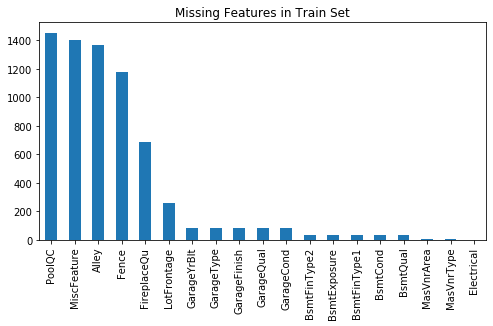

In [8]:
check_missingness(train)[:20].plot(kind='bar')
plt.title('Missing Features in Train Set')
plt.savefig('train_missing.png',bbox_inches='tight')


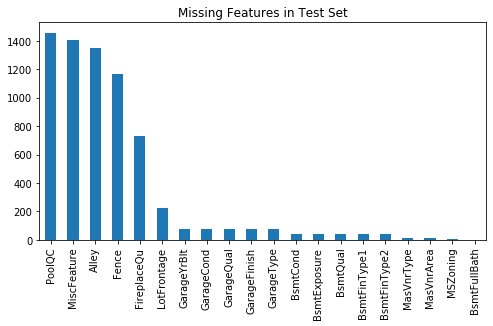

In [9]:
check_missingness(test)[:20].plot(kind='bar')
plt.title('Missing Features in Test Set')

plt.savefig('test_missing.png',bbox_inches='tight')

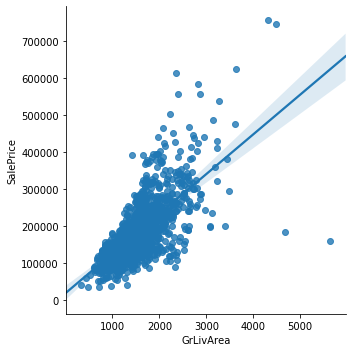

In [10]:
sns.lmplot(x='GrLivArea', y= 'SalePrice', data=train)
plt.savefig('saleprice_grlivarea.png',bbox_inches='tight')


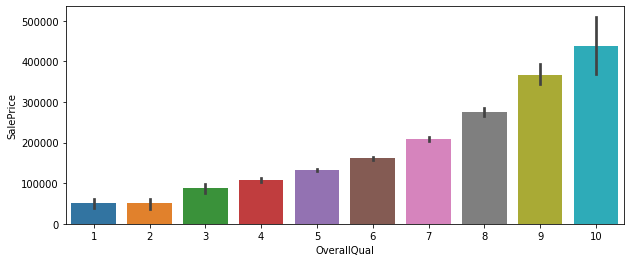

In [11]:
plt.rcParams['figure.figsize']= [10.0, 4.0]
sns.barplot(train.OverallQual, train.SalePrice)
plt.savefig('overallqual.png',bbox_inches='tight')

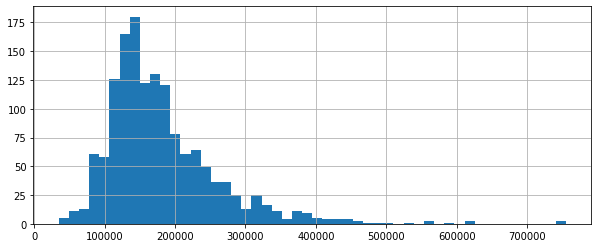

In [12]:
train.SalePrice.hist(bins=50)
plt.savefig('saleprice.png',bbox_inches='tight')

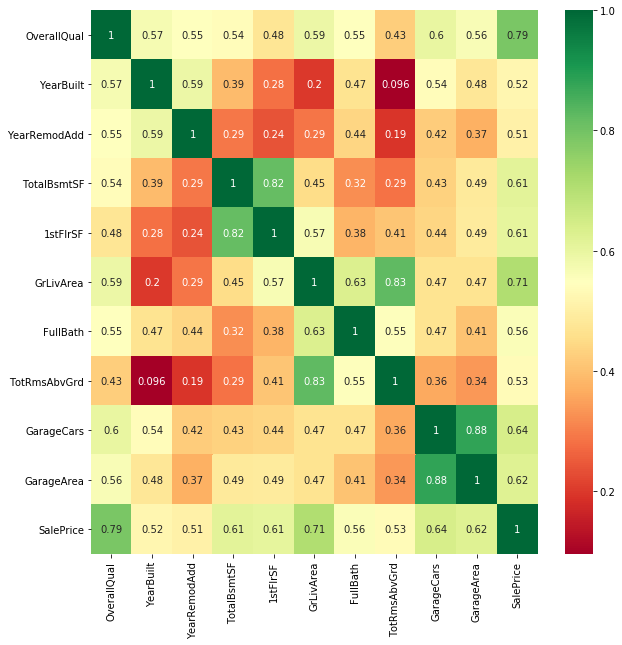

In [13]:
plt.rcParams['figure.figsize']= [10.0, 10.0]
corr=train.corr()
sns.heatmap(train[corr[corr['SalePrice'].abs()>0.5].index].corr(),annot=True,cmap="RdYlGn")
plt.savefig('heatmap.png',bbox_inches='tight')


### Data Processing

#### missing garage data are not at random
Peeking at the missing entries for garage related data, they are not at random, it is reasonable to them filled with "None" for categorical or 0 for numerical.

In [14]:
def process_missing(df):
   
    # fill LotFrontage missings with median value in the same neighborhood
    df['LotFrontage'] = df[['Neighborhood','LotFrontage']].groupby('Neighborhood').transform(lambda x: x.fillna(x.median()))

    # impute MSZoning missings as the most frequent value in the same MSSubClass
    df['MSZoning'] = df[['MSSubClass', 'MSZoning']].groupby('MSSubClass').transform(lambda x: x.fillna(x.mode()[0]))

    df['Utilities'] =df['Utilities'].fillna(df['Utilities'].mode()[0])

    df['Exterior1st'] = df['Exterior1st'].fillna('Wd Sdng')
    df['Exterior2nd'] = df['Exterior2nd'].fillna('Wd Sdng')

    df['Electrical']=df.groupby('Neighborhood')['Electrical'].transform(lambda x: x.fillna(x.mode()[0]))

    df['Functional'] = df['Functional'].fillna(df['Functional'].mode()[0])
    df['KitchenQual'] = df.groupby('Neighborhood')['KitchenQual'].transform(lambda x: x.mode()[0])
    df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
    
    df[numeric_feat1] = df[numeric_feat1].fillna(0)
    df[categorical_feat1] = df[categorical_feat1].fillna('None')

    #print(df.head())
    return df

In [15]:
all_data = pd.concat([train.copy().drop(columns=['SalePrice']), test.copy()], axis=0)

In [16]:
all_data = process_missing(all_data)

In [17]:
all_data.isnull().any().sum()

# checking if there is any more missing entries

0

### Feature Engineering

In [18]:
def Feat_engineering1(data):
    df = data.copy()
    # drop 'Id', 'Street', 'Utilities','PoolQC'
    to_remove=set(['Id', 'Street', 'Utilities','PoolQC', 'PoolArea', 'HalfBath', 'BsmtHalfBath', 'FullBath', 'BsmtFullBath',\
                 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'WoodDeckSF','TotalBsmtSF', '1stFlrSF',\
                  '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'YearBuilt', 'YearRemodAdd'])
    # convert PoolArea to binary
    df['HasPool'] = df['PoolArea'].apply(lambda x: 'Yes' if x>0 else 'No')

    # convert to categorical
    df[['KitchenAbvGr', 'TotRmsAbvGrd', 'BedroomAbvGr', 'GarageCars']] = df[['KitchenAbvGr', 'TotRmsAbvGrd', 'BedroomAbvGr', 'GarageCars']].astype(str)

    # combine features of 'HalfBath', 'BsmtHalfBath', 'FullBath', 'BsmtFullBath'
    df['TotalBath'] = df['HalfBath']/2 + df['BsmtHalfBath']/2 + df['FullBath'] + df['BsmtFullBath']
    df['TotalBath'] = df['TotalBath'].astype('str')

    # combine features of 'OpenPorchSF', 'EnclosedPorch', 'X3SsnPorch', 'ScreenPorch', 'WoodDeckSF'
    df['Total_PorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

    # combine features of TotalSF = TotalBsmtSF + X1stFlrSF + X2ndFlrSF
    df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

    # combine features of 'BsmtFinSF1', 'BsmtFinSF2', 'X1stFlrSF', 'X2ndFlrSF'
    df['TotalFinSF'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']

    # combine 'YearBuilt', 'YearRemodAdd'
    df['YearBuildRemod'] = df['YearBuilt'] + df['YearRemodAdd']

    # add new features
    df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 'Yes' if x>0 else 'No')

    df['Has2ndFlr'] = df['2ndFlrSF'].apply(lambda x: 'Yes' if x>0 else 'No')

    df['HasBasement'] = df['TotalBsmtSF'].apply(lambda x: 'Yes' if x>0 else 'No')

    new_columns = list(set(df.columns).difference(to_remove))
    

    return df[new_columns]
    

In [19]:
def Feat_engineering(data):
    df = data.copy()
    
     # convert to categorical
    to_categorical = ['KitchenAbvGr', 'TotRmsAbvGrd', 'BedroomAbvGr', 
                      'GarageCars', 'HalfBath','BsmtHalfBath',
                      'FullBath','BsmtFullBath','Fireplaces']
    
    df[to_categorical] = df[to_categorical].astype(str)

    # drop features
    to_remove=set(['Id', 'Street', 'Utilities','PoolQC'])
    new_columns = list(set(df.columns).difference(to_remove))
    
    return df[new_columns]
    

In [20]:
all_data = Feat_engineering(all_data)

In [21]:
categorical_feat = all_data.columns[all_data.dtypes=='object']
numeric_feat = all_data.columns[all_data.dtypes!='object']

In [22]:
print(len(categorical_feat))
print(len(numeric_feat))

49
27


### skew transform 


In [23]:
def skew_transform(data):
    df = data.copy()
    skew_features = df.apply(lambda x: skew(x)).sort_values(ascending=False)

    high_skew = skew_features[skew_features > 0.75]
    skew_index = high_skew.index
    print(skew_index)

    df[skew_index] = df[skew_index].apply(lambda x: boxcox1p(x, boxcox_normmax(x+1)))
    return df

In [24]:
all_data[numeric_feat] = skew_transform(all_data[numeric_feat])

Index(['MiscVal', 'PoolArea', 'LotArea', 'LowQualFinSF', '3SsnPorch',
       'BsmtFinSF2', 'EnclosedPorch', 'ScreenPorch', 'MasVnrArea',
       'OpenPorchSF', 'WoodDeckSF', 'LotFrontage', '1stFlrSF', 'BsmtFinSF1',
       'MSSubClass', 'GrLivArea', 'TotalBsmtSF', 'BsmtUnfSF', '2ndFlrSF'],
      dtype='object')


C:\Users\jtlqh\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\jtlqh\Anaconda3\lib\site-packages\scipy\stats\stats.py:3429: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficent may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [25]:
salePrice = np.log(train.SalePrice)

In [26]:
plt.rcParams['figure.figsize']= [10.0, 4.0]

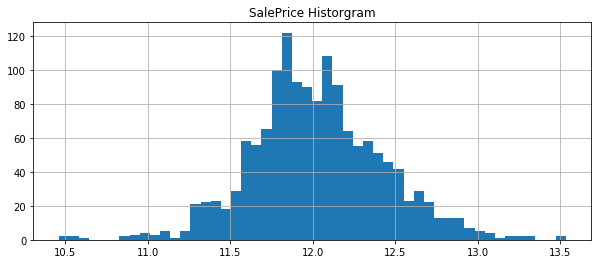

In [27]:
salePrice.hist(bins=50)
plt.title('SalePrice Historgram')
plt.savefig('saleprice_log.png',bbox_inches='tight')


In [28]:
numeric_feat

Index(['GarageYrBlt', 'MiscVal', '1stFlrSF', 'ScreenPorch', 'LotArea',
       'MSSubClass', '2ndFlrSF', 'BsmtFinSF2', '3SsnPorch', 'YrSold',
       'WoodDeckSF', 'BsmtFinSF1', 'LowQualFinSF', 'TotalBsmtSF', 'GarageArea',
       'BsmtUnfSF', 'OpenPorchSF', 'YearRemodAdd', 'LotFrontage',
       'OverallQual', 'PoolArea', 'OverallCond', 'GrLivArea', 'YearBuilt',
       'MasVnrArea', 'MoSold', 'EnclosedPorch'],
      dtype='object')

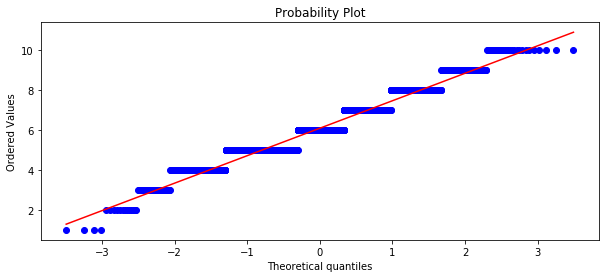

In [29]:
probplot(all_data['OverallQual'], plot=plt)
plt.savefig('overallqual transformed.png',bbox_inches='tight')

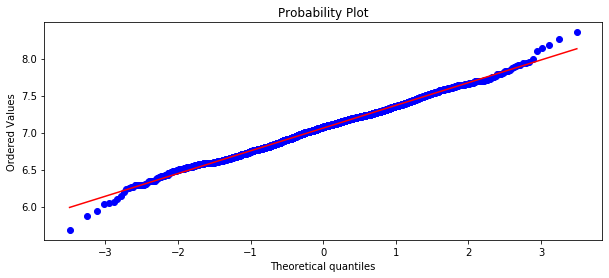

In [31]:
probplot(all_data['GrLivArea'], plot=plt)
plt.savefig('GrLivArea transform.png',bbox_inches='tight')

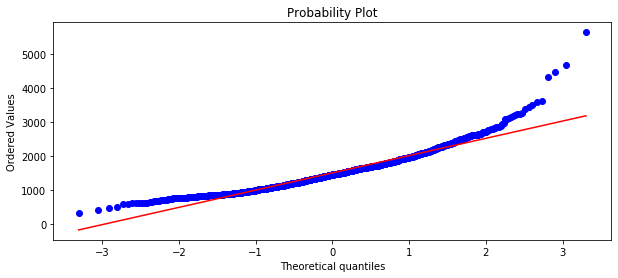

In [32]:
probplot(train['GrLivArea'], plot=plt)
plt.savefig('GrLivArea before.png',bbox_inches='tight')

In [33]:
from scipy.stats import zscore
z_score = {}
for i in numeric_feat:
    z_score[i] = zscore(all_data[i])
z_score = pd.DataFrame(z_score)
z_score = z_score.head(train.shape[0])
for i in ['OverallQual','GrLivArea']:
    print(i,z_score[np.abs(z_score[i])>3.5][i].sort_values(ascending=False))

OverallQual 533   -3.610024
375   -3.610024
Name: OverallQual, dtype: float64
GrLivArea 1298    4.218663
523     3.646113
1182    3.512723
1100   -3.640328
533    -4.481538
Name: GrLivArea, dtype: float64


In [388]:
# choose the highest z_score from two ends as outlier
# two outliers case
outliers = [1298, 533] 

# four outliers case
outliers = [1298, 533, 523, 1100]


In [389]:

to_drop = list(map(lambda x: x[0]+'_'+x[1],[(i, all_data[i].mode()[0]) for i in categorical_feat]))
    

In [390]:
cat_dummy = pd.get_dummies(all_data[categorical_feat]).drop(columns=to_drop)

In [391]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data_label = all_data.copy()
for i in categorical_feat:
    data_label[i] = le.fit_transform(data_label[i]) 

In [392]:
data_dummy = pd.concat([cat_dummy,all_data[numeric_feat]], axis=1)


In [393]:
X=data_dummy.head(train.shape[0])
X.drop(outliers, inplace=True)
y=salePrice.copy()
y.drop(outliers, inplace=True)

In [394]:
X_le=data_label.head(train.shape[0])
X_le.drop(outliers, inplace=True)


In [395]:
X.shape

(1456, 287)

In [47]:
X_le.shape

(1456, 76)

In [48]:
y.shape

(1456,)

In [49]:
def get_error(X_train,y_train,X_test,y_test, model, show = True, refit = True):
    if refit: model.fit(X_train, y_train)
    train_error = 1 - r2_score(y_train, model.predict(X_train))
    test_error = 1 - r2_score(y_test,model.predict(X_test))
    if show:
        print("train error ", train_error)
        print("test error", test_error)
    return [train_error, test_error]



In [396]:

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=108)
train_idx = X_train.index
test_idx = X_test.index

In [32]:
plt.rcParams['figure.figsize']= [6.0, 5.0]

### Modeling

#### Ridge Regression

In [398]:
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

In [399]:
ridge = Ridge(alpha=6.666666666666667, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=108, solver='auto', tol=0.001)
ridge.fit(X_train, y_train)
get_error(X_train,y_train,X_test,y_test,ridge, True,False)

train error  0.05469140188307464
test error 0.07650072167427635


[0.05469140188307464, 0.07650072167427635]

In [53]:
grid_para = dict(alpha = np.linspace(0,20,10))
ridge.set_params(random_state=108, tol=0.001)
grid_search_ridge = ms.GridSearchCV(ridge,  cv=5, param_grid=grid_para, n_jobs=-1, verbose=0)
%time grid_search_ridge.fit(X_train,y_train)  # What to call to trigger the gridSearchCV
ridge=grid_search_ridge.best_estimator_
print(ridge)
get_error(X_train,y_train,X_test,y_test,ridge, True,False) 

Wall time: 2.98 s
Ridge(alpha=6.666666666666667, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=108, solver='auto', tol=0.001)
train error  0.05469140188307475
test error 0.07650072167427613


C:\Users\jtlqh\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0.05469140188307475, 0.07650072167427613]

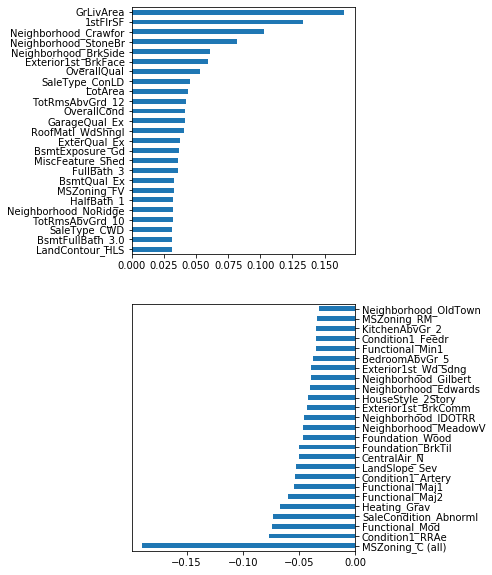

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=1,  figsize=(4, 10*1))
plt.plot
coef = pd.Series(ridge.coef_,index=X_train.columns).sort_values()
coef.tail(25).plot(kind='barh', ax=axs[0])
coef.head(25).plot(kind='barh', ax=axs[1])
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()
plt.savefig('ridge coef.png',bbox_inches='tight')

#### Lasso Regression

In [400]:
lasso = Lasso(alpha=0.0007199999999999999, copy_X=True, fit_intercept=True,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=108, selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(X_train, y_train)
print(get_error(X_train, y_train, X_test, y_test, lasso))

mean_squared_error(y_test, lasso.predict(X_test))

train error  0.06478009964378395
test error 0.07577115256147171
[0.06478009964378395, 0.07577115256147171]


0.011467949244723491

In [56]:
grid_para = dict(alpha = np.linspace(.0005,0.0009,21))
grid_search_lasso = ms.GridSearchCV(lasso,  cv=5 ,param_grid=grid_para, n_jobs=-1)
%time grid_search_lasso.fit(X_train,y_train)  # What to call to trigger the gridSearchCV
lasso=grid_search_lasso.best_estimator_
print(lasso)

print(get_error(X_train, y_train, X_test, y_test, lasso))
mean_squared_error(y_test, lasso.predict(X_test))

Wall time: 1.88 s
Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=108,
      selection='cyclic', tol=0.0001, warm_start=False)
train error  0.060276439096487056
test error 0.0755411408219705
[0.060276439096487056, 0.0755411408219705]


0.011433137012559677

In [401]:
net = ElasticNet(alpha=0.00074, copy_X=True, fit_intercept=True, l1_ratio=0.99, max_iter=1000, normalize=False, positive=False,
           precompute=False, random_state=108, selection='cyclic', tol=0.0001,
           warm_start=False)
net.fit(X_train, y_train)
print(get_error(X_train, y_train, X_test, y_test, net))

mean_squared_error(y_test, net.predict(X_test))

train error  0.06503819332121541
test error 0.07576596743337305
[0.06503819332121541, 0.07576596743337305]


0.011467164476591402

In [58]:
grid_para = dict(alpha = np.linspace(0.0005,0.0009,11), l1_ratio=np.linspace(0.99,.999,2))
grid_search_net = ms.GridSearchCV(net,  cv=5, scoring = 'r2', param_grid=grid_para, n_jobs=-1)
%time grid_search_net.fit(X_train,y_train)  # What to call to trigger the gridSearchCV
net=grid_search_net.best_estimator_

print(net)
print(get_error(X_train, y_train, X_test, y_test, net))

mean_squared_error(y_test, net.predict(X_test))

Wall time: 1.89 s
ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.999,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=108, selection='cyclic', tol=0.0001, warm_start=False)
train error  0.06026647012637365
test error 0.075539222610993
[0.06026647012637365, 0.075539222610993]


0.011432846691700254

In [402]:
X_train, X_test = X_le.loc[train_idx], X_le.loc[test_idx] 
X_train.shape

(1164, 76)

### Support Vector Machine

In [403]:
svm = SVR(C=1300, cache_size=200, coef0=0.0, degree=3, epsilon=0.025,
    gamma=1.8999999999999998e-07, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
print(svm)
svm.fit(X_train, y_train)

get_error(X_train,y_train, X_test,y_test,svm, True,False)

SVR(C=1300, cache_size=200, coef0=0.0, degree=3, epsilon=0.025,
    gamma=1.8999999999999998e-07, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
train error  0.08826184684616678
test error 0.09878958639280222


[0.08826184684616678, 0.09878958639280222]

In [80]:
grid_para_svm = [
    {'C': [1300],#np.linspace(1200,1600,5),
     'gamma': np.linspace(1e-7,1e-6,11),
     'epsilon': [.025],#np.logspace(-2,0,6),
     'degree': [3]
     #'kernel': ['rbf']
    }
]
#grid_search_svm =ms.RandomizedSearchCV(svm, grid_para_svm, cv = 5, n_jobs = -1, random_state=108)
grid_search_svm = ms.GridSearchCV(svm, param_grid=grid_para_svm, cv=5, return_train_score=True,  n_jobs=-1)
%time grid_search_svm.fit(X_train, y_train)

svm =grid_search_svm.best_estimator_
print(svm)

print(get_error(X_train,y_train, X_test, y_test, svm))

Wall time: 14.7 s
SVR(C=1300, cache_size=200, coef0=0.0, degree=3, epsilon=0.025,
    gamma=1.8999999999999998e-07, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)
train error  0.08826184684675109
test error 0.09878958639163438
[0.08826184684675109, 0.09878958639163438]


#### Random Forest

In [404]:

rf = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=19,
                      max_features=23, max_leaf_nodes=None,
                      min_impurity_decrease=1e-06, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0001, n_estimators=58,
                      n_jobs=None, oob_score=False, random_state=108, verbose=0,
                      warm_start=False)

print(rf)
rf.fit(X_train,y_train)
print(get_error(X_train, y_train, X_test, y_test, rf))
mean_squared_error(y_test, rf.predict(X_test))


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=19,
                      max_features=23, max_leaf_nodes=None,
                      min_impurity_decrease=1e-06, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0001, n_estimators=58,
                      n_jobs=None, oob_score=False, random_state=108, verbose=0,
                      warm_start=False)
train error  0.010663505147377683
test error 0.11124103540389141
[0.010663505147377683, 0.11124103540389141]


0.016836309133708358

In [83]:
grid = {
               'max_features': range(10,25),
               'max_depth': range(10,25),
               'min_samples_split': [2],
               'min_samples_leaf': [3],
                'n_estimators': range(30,60,2),
              'min_weight_fraction_leaf':[0.0001],
              'min_impurity_decrease':[0.000001]
}
grid_search_forest = ms.GridSearchCV(rf, grid, cv=5,  n_jobs=-1)
#grid_search_forest = ms.RandomizedSearchCV(rf, random_grid, scoring ='r2', cv = 5, n_jobs = -1, random_state=108)
%time grid_search_forest.fit(X_train, y_train)   # %time     is ipython magic command to measure the execution timebest_net=grid_search_net.best_estimator_

rf = grid_search_forest.best_estimator_
print(rf)

print(get_error(X_train, y_train, X_test, y_test, rf))
mean_squared_error(y_test, rf.predict(X_test))

Wall time: 6min 8s
RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=21,
                      max_features=24, max_leaf_nodes=None,
                      min_impurity_decrease=1e-06, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0001, n_estimators=56,
                      n_jobs=None, oob_score=False, random_state=108, verbose=0,
                      warm_start=False)
train error  0.011116894208845984
test error 0.11340667388231784
[0.011116894208845984, 0.11340667388231784]


0.0171640780974029

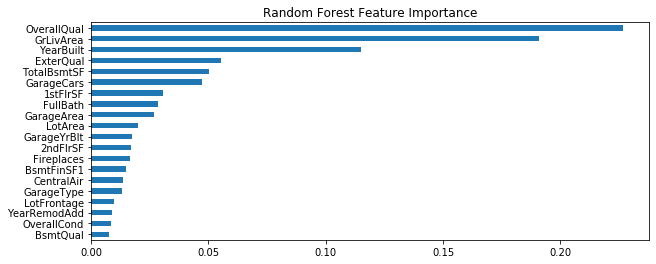

In [84]:
importance_rf = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)
importance_rf.tail(20).plot(kind='barh', x=0, y=1)
plt.title('Random Forest Feature Importance')
plt.savefig('rf_features.png',bbox_inches='tight')

#### Gradient Boosting Machine

In [405]:
gbmr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='ls', max_depth=3,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2800,
                          n_iter_no_change=None, presort='auto',
                          random_state=108, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
print(gbmr)
gbmr.fit(X_train,y_train)
print(get_error(X_train, y_train, X_test, y_test, gbmr))
mean_squared_error(y_test, gbmr.predict(X_test))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='ls', max_depth=3,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2800,
                          n_iter_no_change=None, presort='auto',
                          random_state=108, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
train error  0.01295720503894393
test error 0.0834706858287978
[0.01295720503894393, 0.0834706858287978]


0.012633272111445383

In [90]:
param_grid = {'n_estimators': range(3000,5000,100),
               'max_features': [2],#range(2,4),
               'max_depth': [3],#range(2,4),
               'min_samples_split': [2],
               'min_samples_leaf': [2],
               'learning_rate': [.03],#np.linspace(0.02,0.03,11),
                'subsample':[0.9]}
grid_search_gbmr =ms.GridSearchCV(gbmr, param_grid=param_grid, cv=5, #scoring='neg_mean_squared_error', \
                                  return_train_score=True,n_jobs=-1, )
%time grid_search_gbmr.fit(X_train,y_train)

gbmr=grid_search_gbmr.best_estimator_
print(gbmr)

print(get_error(X_train, y_train, X_test, y_test, gbmr))
mean_squared_error(y_test, gbmr.predict(X_test))

Wall time: 19.8 s
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.03, loss='ls', max_depth=3,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=2, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=3000,
                          n_iter_no_change=None, presort='auto',
                          random_state=108, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
train error  0.01142983604318859
test error 0.07816976846912416
[0.01142983604318859, 0.07816976846912416]


0.011830979297146526

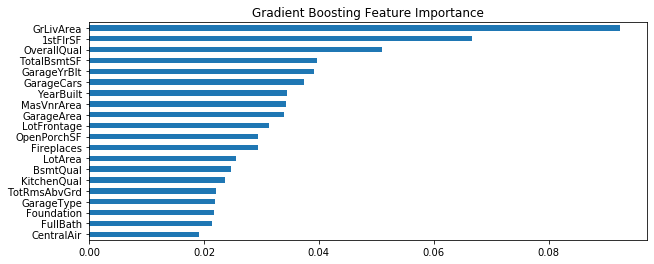

In [91]:
importance_gbmr = pd.Series(gbmr.feature_importances_, index=X_train.columns).sort_values(ascending=True)
importance_gbmr.tail(20).plot(kind='barh', x=0, y=1)
plt.title('Gradient Boosting Feature Importance')
plt.savefig('gbm_features.png',bbox_inches='tight')

#### Xgboost Regression

In [406]:
warnings.filterwarnings('ignore')
xgb = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.7, colsample_bytree=0.4, gamma=0.0,
             importance_type='gain', learning_rate=0.028999999999999998,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=800, n_jobs=-1, nthread=-1, objective='reg:linear',
             random_state=108, reg_alpha=0.4, reg_lambda=0.5, 
            scale_pos_weight=1, seed=0, silent=None, subsample=1, verbosity=1)
print(xgb)

%time xgb.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_test, y_test)], early_stopping_rounds=100,verbose=False)
print(get_error(X_train, y_train, X_test, y_test, xgb))
mean_squared_error(y_test, xgb.predict(X_test))


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.7, colsample_bytree=0.4, gamma=0.0,
             importance_type='gain', learning_rate=0.028999999999999998,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=800, n_jobs=-1, nthread=-1, objective='reg:linear',
             random_state=108, reg_alpha=0.4, reg_lambda=0.5,
             scale_pos_weight=1, seed=0, silent=None, subsample=1, verbosity=1)
[08:05:22] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 449 ms
[08:05:23] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train error  0.03327483013087751
test error 0.09020273799082101
[0.03327483013087751, 0.09020273799082101]


0.013652166900518046

In [93]:
params = {'n_estimators': range(500,1500,100),# 
          'max_depth': [3], #range(3,10),
          'min_child_weight':[1],#range(1,6),#[1], 
          'gamma': [0.0],#np.linspace(0,.4,5),#[0],
          'subsample':[1],
          'colsample_bytree':[0.4],
          'scale_pos_weight':[1],
          'learning_rate': np.linspace(0.01,0.2,11),
          'reg_alpha':[0.4],#np.linspace(0,.5,6),
          'reg_lambda':[0.5],#np.linspace(1,.1,11)
         }

grid_search_xgb = ms.GridSearchCV(xgb, params, cv=5, #scoring='neg_mean_squared_error',\
                                  return_train_score=True, n_jobs=-1)
%time grid_search_xgb.fit(X_train, y_train, eval_metric='rmse', eval_set=[(X_test, y_test)], \
                          early_stopping_rounds=11, verbose =0)

xgb=grid_search_xgb.best_estimator_

print(xgb)

print(get_error(X_train, y_train, X_test, y_test, xgb))
mean_squared_error(y_test, xgb.predict(X_test))

[05:56:41] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Wall time: 28.7 s
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=0.7, colsample_bytree=0.4, gamma=0.0,
             importance_type='gain', learning_rate=0.028999999999999998,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=800, n_jobs=-1, nthread=-1, objective='reg:linear',
             random_state=108, reg_alpha=0.4, reg_lambda=0.5,
             scale_pos_weight=1, seed=0, silent=None, subsample=1, verbosity=1)
[05:56:41] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train error  0.03442934951176102
test error 0.0916402366214999
[0.03442934951176102, 0.0916402366214999]


0.013869732039475266

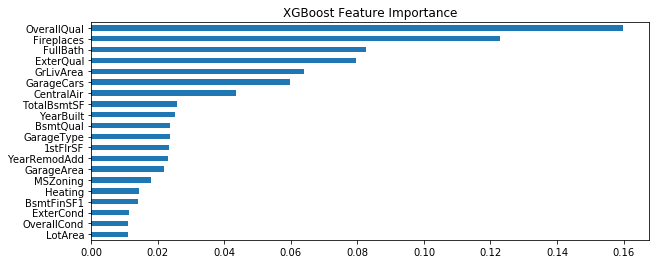

In [98]:
importance_xgb = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values()
importance_xgb.tail(20).plot(kind='barh', x=0, y=1)

plt.title('XGBoost Feature Importance')
plt.savefig('XGBoost_features.png',bbox_inches='tight')


### Asemble all models

In [407]:
models = {'ridge':ridge, 'lasso':lasso,'ElasticNet':net, 'svm':svm,'forest':rf, 'gradient boost':gbmr, 'xgboost':xgb}
models = pd.Series(models)

In [408]:
mse = {}
for i,model in models.items():
    if model in [ridge, lasso, net]:
        mse[i] = 1-r2_score(y_test, model.predict(X.loc[test_idx])) 
    else:
        mse[i]= 1- r2_score(y_test, model.predict(X_le.loc[test_idx]))
pd.Series(mse).sort_values()

ElasticNet        0.075766
lasso             0.075771
ridge             0.076501
gradient boost    0.083471
xgboost           0.090203
svm               0.098790
forest            0.111241
dtype: float64

### Fit Models

In [101]:
for model in models:
    if model in [ridge, lasso, net]:
        model.fit(X, y)
    else:
        model.fit(X_le,y)

[06:00:29] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [102]:
mse = pd.Series(index=models.index)
for i,model in models.items():
    if model in [ridge, lasso, net]:
        mse[i] = mean_squared_error(y, model.predict(X))
    else:
        mse[i] = mean_squared_error(y, model.predict(X_le))
mse.sort_values()

forest            0.001680
gradient boost    0.002473
xgboost           0.005624
ridge             0.008846
ElasticNet        0.009901
lasso             0.009903
svm               0.013496
dtype: float64

### SalePrice Prediction

In [103]:
print(test.shape)
submissions = pd.DataFrame(index=test.index)
submissions['Id'] =test['Id']


(1459, 80)


In [104]:
data_dummy_test = data_dummy.tail(test.shape[0])
data_le_test = data_label.tail(test.shape[0])


In [105]:
print(submissions.shape, data_dummy_test.shape, data_le_test.shape)

(1459, 1) (1459, 287) (1459, 76)


In [106]:
# y prediction
for i in models.index:
    if models[i] in [ridge, lasso, net]:
        submissions[i] = models[i].predict(data_dummy_test)
    else:
        submissions[i] = models[i].predict(data_le_test)


In [107]:
submissions.iloc[:,1:] = submissions.iloc[:,1:].apply(lambda x: np.round(np.exp(x),1), axis=1)

submissions.head(10)

,Id,ridge,lasso,ElasticNet,svm,forest,gradient boost,xgboost
0,1461,124736.3,125606.3,125603.6,124583.4,120476.5,126819.9,126049.5
1,1462,155622.0,158748.2,158751.5,159812.5,154292.5,163256.1,158196.8
2,1463,188870.6,187428.5,187428.9,189165.9,178840.5,188051.6,189264.9
3,1464,201191.6,204527.3,204523.4,198890.9,185179.2,199603.3,192688.3
4,1465,194575.9,195025.1,195028.7,186993.0,188700.0,190259.6,192963.6
5,1466,169970.8,170677.3,170676.0,176727.0,183669.4,177953.4,175110.2
6,1467,175504.0,180124.6,180121.9,183594.0,175454.3,178715.8,176319.1
7,1468,159262.7,160879.7,160877.0,158901.5,175569.9,171687.4,164809.2
8,1469,191023.9,196446.0,196443.7,179993.7,181194.6,172323.8,182227.0
9,1470,119581.3,118491.8,118494.0,121374.9,124251.8,123195.5,120852.2


In [108]:
comp = pd.read_csv('top 1 sample.csv')

In [110]:
# comparing preditions with top 1% kaggle submission, linear models have the best results
comp_result={}
for i in models.index:
    comp_result[i]= np.sqrt((submissions[i]- comp['SalePrice'])**2).mean()

In [111]:
pd.Series(comp_result).sort_values()

ElasticNet         5226.249061
lasso              5226.846594
ridge              5304.375175
xgboost            6544.821097
gradient boost     6639.166539
svm                9911.751528
forest            10289.879287
dtype: float64

### Blending Models

In [127]:
# msre 8601 with top 1%, kaggle score .11700, top 16.3%
weights = pd.Series({'ridge':0.26, 'lasso':0.26, 'ElasticNet':0.26, 'svm':0.01,'forest':0.01, 'gradient boost':0.1, 'xgboost':0.1})
print(weights.sum())

# checking mean square error root with top 1 submission
np.sqrt((((submissions.drop('Id', 1)*weights).sum(axis=1)-comp['SalePrice'])**2).mean())


1.0


8601.880154634226

In [144]:
# msre 8497 with top 1%, kaggle score .11697, position at top 16.2%
weights = pd.Series({'ridge':0.25, 'lasso':0.25, 'ElasticNet':0.25, 'svm':0.01,'forest':0.01, 'gradient boost':0.1, 'xgboost':0.13})
print(weights.sum())

# checking mean square error root with top 1 submission
np.sqrt((((submissions.drop('Id', 1)*weights).sum(axis=1)-comp['SalePrice'])**2).mean())


1.0


8497.851525546186

In [145]:
submissions['blend']=np.round((submissions*weights).sum(axis=1), 1)

In [146]:
for name in submissions.columns[1:]:
    data=submissions[['Id', name]]
    data.columns=['Id','SalePrice']
    data.to_csv(name+"_py4.csv", index=False)


### Kaggle Score for Models

In [148]:
kaggle_score={}
kaggle_score['two outliers']={'ridge':.11926, 'lasso':.11910, 'ElasticNet':.11912,'svm':.13582,'random forest':.14278, 'gradient boost':.12790, 'xgboost':.12734, 'blend':.11752}
kaggle_score['four outliers']={'ridge':.11814, 'lasso':.11812, 'ElasticNet':.11812,'svm':.14361,'random forest':.14206, 'gradient boost':.12831, 'xgboost':.12373, 'blend':.11697}

print('Kaggle Scores\n{}'.format(pd.DataFrame(kaggle_score).sort_values(by='four outliers')))

Kaggle Scores
                two outliers  four outliers
blend                0.11752        0.11697
ElasticNet           0.11912        0.11812
lasso                0.11910        0.11812
ridge                0.11926        0.11814
xgboost              0.12734        0.12373
gradient boost       0.12790        0.12831
random forest        0.14278        0.14206
svm                  0.13582        0.14361


The blended model has kaggle score 0.11697, puts my position at 16.2% at the time of submission